In [29]:
import numpy as np 
import matplotlib.pyplot as plt
import re

storage_engines_labels = ['SQLite3', 'ForestDB', 'LevelDB']

storage_engines_labels_axis = np.arange(len(storage_engines_labels))

# IMPORTANT: Counting total number of bytes in pages is illogical - Pages are NOT always fully filled up

log_line_pattern = r'^\s*\d\s+\d+\s+(W|R)\s+(\d+).+$'

def analyze_disk_io_for(disk_io_log_file):
    log_file = open(disk_io_log_file, 'r')

    line_count = 0

    io = { 'R': 0, 'W': 0 }
    blocks = set()

    for log_line in log_file:
        line_count += 1

        if line_count == 1 or len(log_line.strip()) == 0:
            continue

        match = re.match(log_line_pattern, log_line)

        if match is None:
            continue

        operation_type = match.group(1)
        block_number = int(match.group(2))

        io[operation_type] += 1
        blocks.add(block_number)

    reads = io['R']
    writes = io['W']

    total_blocks = len(blocks)

    log_file.close()

    return reads, writes, reads + writes, total_blocks

sqlite3_disk_io_metrics = analyze_disk_io_for('../benchmarks/sqlite3/disk_io_log')
forestdb_disk_io_metrics = analyze_disk_io_for('../benchmarks/forestdb/disk_io_log')
leveldb_disk_io_metrics = analyze_disk_io_for('../benchmarks/leveldb/disk_io_log')

No handles with labels found to put in legend.


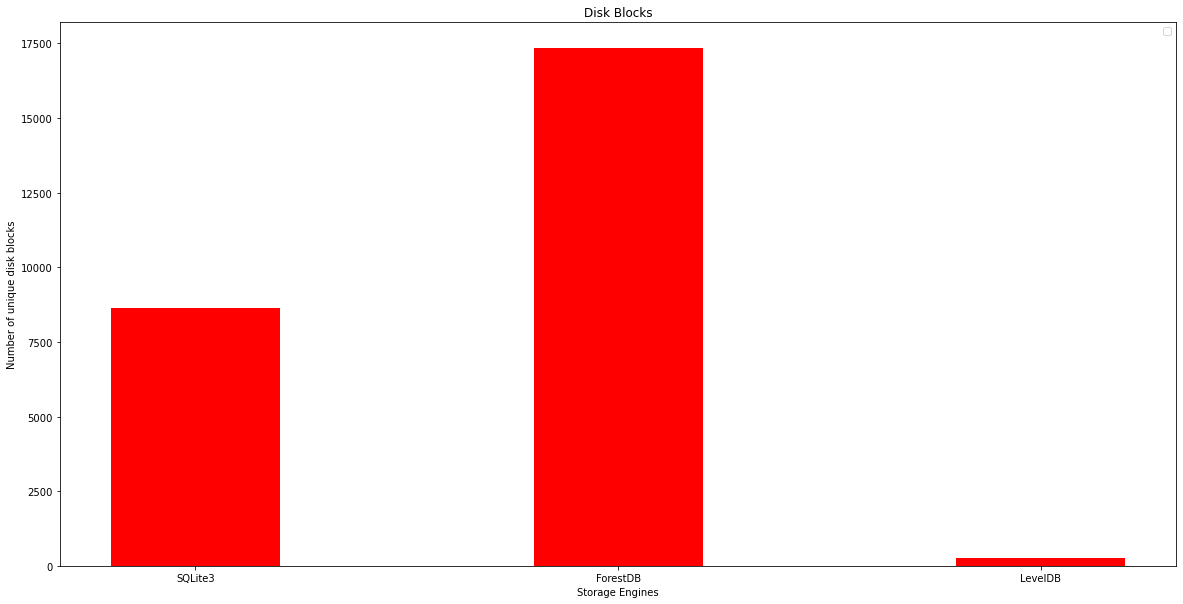

SQLite
8630 blocks used

ForestDB
17340 blocks used

LevelDB
269 blocks used



In [30]:
numbers_of_blocks = [sqlite3_disk_io_metrics[3], forestdb_disk_io_metrics[3], leveldb_disk_io_metrics[3]]

plt.figure(figsize = (20, 10))

plt.bar(storage_engines_labels, numbers_of_blocks, width=0.4, color='red')

plt.title('Disk Blocks')
plt.xlabel('Storage Engines')
plt.ylabel('Number of unique disk blocks')
plt.legend()
plt.show()

print('SQLite')
print(str(sqlite3_disk_io_metrics[3]) + ' blocks used\n')
print('ForestDB')
print(str(forestdb_disk_io_metrics[3]) + ' blocks used\n')
print('LevelDB')
print(str(leveldb_disk_io_metrics[3]) + ' blocks used\n')

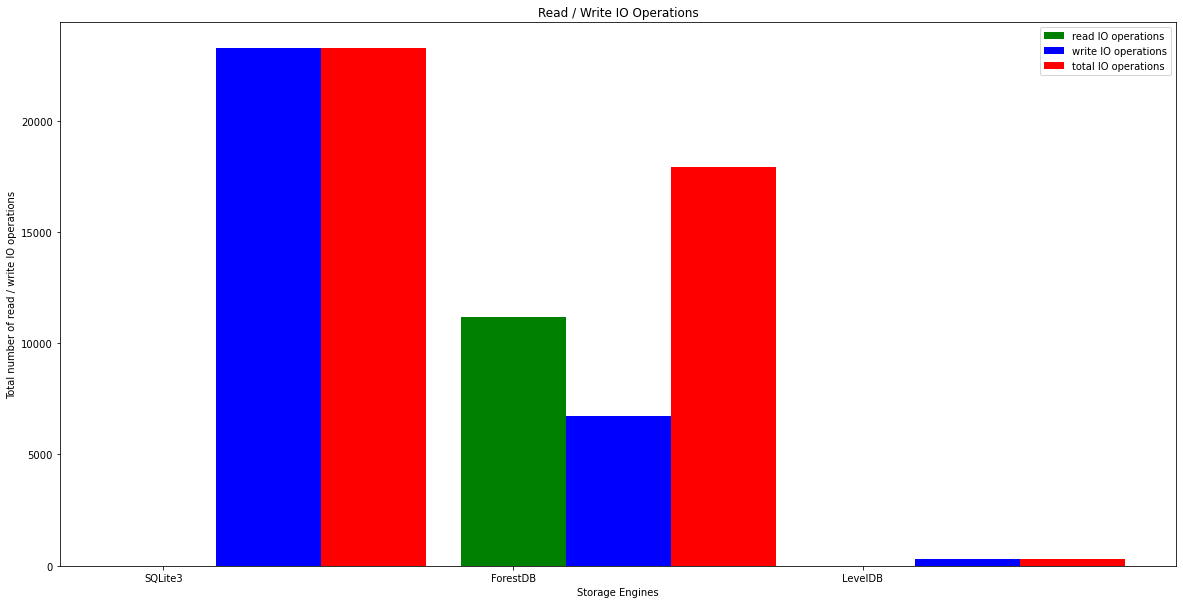

SQLite
1 read(s) and 23252 write(s), 23253 in total

ForestDB
11192 read(s) and 6742 write(s), 17934 in total

LevelDB
2 read(s) and 300 write(s), 302 in total



In [31]:
reads = [sqlite3_disk_io_metrics[0], forestdb_disk_io_metrics[0], leveldb_disk_io_metrics[0]]
writes = [sqlite3_disk_io_metrics[1], forestdb_disk_io_metrics[1], leveldb_disk_io_metrics[1]]
total = [sqlite3_disk_io_metrics[2], forestdb_disk_io_metrics[2], leveldb_disk_io_metrics[2]]

plt.figure(figsize = (20, 10))

plt.bar(storage_engines_labels_axis, reads, 0.3, color='green', label = 'read IO operations')
plt.bar(storage_engines_labels_axis + 0.3, writes, 0.3, color='blue', label = 'write IO operations')
plt.bar(storage_engines_labels_axis + 0.6, total, 0.3, color='red', label = 'total IO operations')

plt.xticks(storage_engines_labels_axis, storage_engines_labels)

plt.title('Read / Write IO Operations')
plt.xlabel('Storage Engines')
plt.ylabel('Total number of read / write IO operations')
plt.legend()
plt.show()

print('SQLite')
print(str(sqlite3_disk_io_metrics[0]) + ' read(s) and ' + str(sqlite3_disk_io_metrics[1]) + ' write(s), ' + str(sqlite3_disk_io_metrics[2]) + ' in total\n')
print('ForestDB')
print(str(forestdb_disk_io_metrics[0]) + ' read(s) and ' + str(forestdb_disk_io_metrics[1]) + ' write(s), ' + str(forestdb_disk_io_metrics[2]) + ' in total\n')
print('LevelDB')
print(str(leveldb_disk_io_metrics[0]) + ' read(s) and ' + str(leveldb_disk_io_metrics[1]) + ' write(s), ' + str(leveldb_disk_io_metrics[2]) + ' in total\n')